# Recursive Quantum Approximate Optimization Algorithm

In this notebook, we provide a short introduction to recursive QAOA, and demonstrate how this technique is implemented in the OpenQAOA workflows by solving a fully-connected Hamiltonian with $\pm 1$ weights.

### A brief introduction to RQAOA

Recursive QAOA (RQAOA) is an iterative variant of QAOA, first introduced by Bravyi et al. in [1] and further explored in [2,3]. 

This technique consists in recursively reducing the size of the problem by running QAOA. At each step, the QAOA output distribution is used to compute the expectation values 

$$
\mathcal{M}_{i} = \langle Z_{i} \rangle \qquad \qquad \qquad \qquad \qquad \mathcal{M}_{ij} = \langle Z_{i}Z_{j} \rangle,
$$

associated with the terms present in the Hamiltonian. Note that, by definition, these quantities are bounded between -1 and 1. The expectation values are then ranked according to their magnitude $|\mathcal{M}_{(i),(ij)}|$, where we use $\mathcal{M}_{(i),(ij)}$ to generically refer to both single- and two-spin expectation values. In its original formulation, the highest ranked value is selected. This value is then utilized to eliminate a qubit from the Hamiltonian, by imposing a constraint on the respective qubits, according to the nature of the highest ranked expectation value. The two kinds of constraints are

$$
Z_{i} \mapsto \textrm{sign}(\mathcal{M}_{(i)}) \qquad \qquad \textrm{and} \qquad \qquad  Z_{i} \mapsto \textrm{sign}(\mathcal{M}_{(ij)}) Z_{j},
$$

where the expectation value is rounded via the `sign` operation for consistency. The first one can be interpreted as fixing qubit $i$ to a specific state, $| 0 \rangle$ if $\textrm{sign}(\mathcal{M}_{(i)}) > 0$ and $|1 \rangle$ if $\textrm{sign}(\mathcal{M}_{(i)})  < 0$, and the second one as fixing qubit $i$ with respect to the configuration of $j$, i.e. $i$ and $j$ will be aligned if $\textrm{sign}(\mathcal{M}_{(ij)})> 0$ and antialigned otherwise. Inserting the correponding constraint directly into the Hamiltonian, we reduce the size of the problem by one qubit. Using the reduced Hamiltonian, QAOA is then run again and the same procedure is followed. Once the reduced problem reaches a predefined cutoff size $n_{\textrm{cutoff}}$, it is solved exactly via classical methods. The final answer is then reconstructed by re-inserting the eliminated qubits into the classical solution following the appropriate order.

In summary, the process is:

1. Execute QAOA
2. Compute expectation values $\mathcal{M}_{(i),(ij)}$ of terms present in the Hamiltonian
3. Rank expectation values according to their magnitude $|\mathcal{M}_{(i),(ij)}|$
4. Select the expectation value with highest magnitude
5. Eliminate variable by imposing the appropriate constraint and obtain reduced problem
6. If new problem size is smaller than $n_{\textrm{cutoff}}$, obtain final solution classically and reinsert constraints, else, return to step 1 using the reducedproblem

This version of RQAOA is included in OpenQAOA. Additionally, OpenQAOA incorporates RQAOA from two different generalized version of these procedure, which enable multiple qubit eliminations during the recursive process, modifying steps 4 and 5 above. These strategies are denoted as `custom` and `adaptive` [4], in accordance with the precise concept under which the elimination method takes place. In a nutshell, they are described as follows:


* The ``custom`` strategy allows the user to define the number of eliminations to be performed at each step. This is defined by the parameter ``steps``. If the parameter is set as an integer, the algorithm will use this value as the number of qubits to be eliminated at each step. Alternatively, it is possible to pass a list, which specifies the number of qubits to be eliminated at each step. For ``steps = 1``, the algorithm reduces to the original form of RQAOA presented in [1].

* The ``adaptive`` strategy adaptively selects how many qubits to eliminate at each step. The maximum number of allowed eliminations is given by the parameter ``n_max``. At each step, the algorithm selects the top ``n_max+1`` expectation values (ranked in magnitude), computes the mean among them, and uses the ones lying above it for qubit elimination. This corresponds to a maximum of ``n_max`` possible elimination per step. For ``n_max= 1``, the algorithm reduces to the original form of RQAOA presented in [1].

**NOTE**: The specific performance of these generalizations is currently under investigation. In particular, the development of Adaptive RQAOA is associated with an internal research project at Entropica Labs to be released publicly in the near future [4]. We make these strategies already available to the community in order to strengthen the exploration of more complex elimination schemes for RQAOA, beyond its original formulation [1].

## References

[1] S. Bravyi, A. Kliesch, R. Koenig, and E. Tang, [Physical Review Letters 125, 260505 (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.260505) \
[2] S. Bravyi, A. Kliesch, R. Koenig, and E. Tang, [(2020), 10.22331/q-2022-03-30-678](https://quantum-journal.org/papers/q-2022-03-30-678/) \
[3] D. J. Egger, J. Marecek, and S. Woerner, [Quantum 5, 479 (2021)](https://doi.org/10.22331/q-2021-06-17-479) \
[4] E. I. Rodríguez Chiacchio, V. Sharma, E. Munro (Work in progress) 

In [1]:
try:
    import openqaoa_azure
except ImportError:
    !pip -q install openqaoa-azure
    import openqaoa_azure

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from openqaoa import RQAOA, QUBO, create_device
from openqaoa.utilities import ground_state_hamiltonian, plot_graph
from openqaoa.qaoa_components import Hamiltonian

## Setting the problem

We define our problem to be a fully-connected system, where we choose the couplings $J_{ij}$ to be of magnitude 1, but with a randomly assigned signs, and for simplicity we set linear terms to 0. The workflow requires us to define the problem as an instance of the ``QUBO`` (Quadratic Unconstrained Binary Optimization) class, which is easily done by defining the connectivity of the problem and the coupling values.

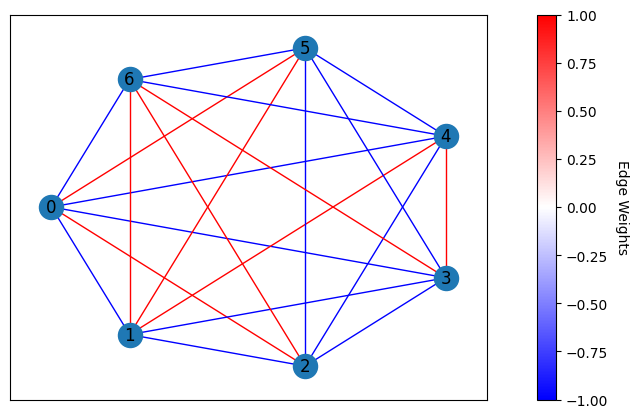

In [3]:
# Number of qubits
n_qubits = 7

# Define fully-connected terms
terms = [(i,j) for j in range(n_qubits) for i in range(j)]

# Assign coupling signs at random
rng = np.random.default_rng(42)
weights = [(-1)**np.round(rng.random()) for _ in range(len(terms))]

# Define QUBO problem
problem = QUBO(n_qubits,terms,weights)

# Plot geometry
problem_graph = nx.Graph()
weighted_edges = [tuple(list(term) + [weight]) for term, weight in zip(terms,weights)] 
problem_graph.add_weighted_edges_from(weighted_edges)

fig, ax = plt.subplots(1,1,figsize = (8,5))

nx.draw_networkx(problem_graph, pos = nx.shell_layout(problem_graph), edge_color = weights, edge_cmap = plt.colormaps["bwr"], ax = ax)

sm = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
cbar = plt.colorbar(sm, pad=0.08, ax = ax)
cbar.ax.set_ylabel("Edge Weights", rotation=270, labelpad=15)

plt.show()

## Run RQAOA on a local simulator 

 We now demonstrate the full RQAOA workflow and how to run it on Azure Quantum devices

In [4]:
# Define an instance of the RQAOA class
r =  RQAOA()

Set up RQAOA properties

In [5]:
n_cutoff = 3 #size at which to solve things classically

n_steps = 1 #  Number of eliminations per step

# Set instance parameters
r.set_rqaoa_parameters(n_cutoff = n_cutoff, steps = n_steps, rqaoa_type = 'custom')

Set up the QAOA properties

In [6]:
# The device chosen here is a local simulator included in OpenQAOA
device = create_device(location='local', name='vectorized')
r.set_device(device)

r.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
r.set_classical_optimizer(method='cobyla', maxiter=200)

In [7]:
# Compile problem instance 
r.compile(problem)

In [8]:
# Solve problem with RQAOA
r.optimize()

In [9]:
# Extract results
result = r.result

 The results show the final solution of the problem, the output from the classical solution on the reduced problem, the set of eliminations performed (on which pair and which correlation), the schedule followed (the number of eliminations at each step), the total number of recursive steps it took to reach the cutoff size and the all the information regarding the problem and QAOA run in the intermediate steps.

In [10]:
result

{'solution': {'1100100': -9.0, '0011011': -9.0},
 'classical_output': {'minimum_energy': -4.0,
  'optimal_states': ['110', '001']},
 'elimination_rules': [[{'pair': (2, 4), 'correlation': -1.0}],
  [{'pair': (2, 4), 'correlation': 1.0}],
  [{'pair': (1, 4), 'correlation': -1.0}],
  [{'pair': (0, 2), 'correlation': -1.0}]],
 'schedule': [1, 1, 1, 1],
 'number_steps': 4,
 'intermediate_steps': [{'counter': 0,
   'problem': <openqaoa.problems.qubo.QUBO at 0x7f38bb1dfe80>,
   'qaoa_results': <openqaoa.algorithms.qaoa.qaoa_result.QAOAResult at 0x7f38b8b06950>,
   'exp_vals_z': array([0., 0., 0., 0., 0., 0., 0.]),
   'corr_matrix': array([[ 0.        ,  0.15351551, -0.22415966,  0.06753463,  0.28993212,
           -0.28993212, -0.15351551],
          [ 0.        ,  0.        ,  0.15351551, -0.15351551,  0.28993212,
            0.22415966,  0.22415966],
          [ 0.        ,  0.        ,  0.        ,  0.22415966, -0.36057627,
            0.36057627, -0.15351551],
          [ 0.        ,  0.

 From the intermediate steps, we can extract useful properties such as the cost optimization, the shape of the system, or the correlation matrix at that step. The ``r.results`` object has some methods that help to get the intermediate steps: ``.get_qaoa_results(step)``, ``.get_problem(step)``, among many others (see https://openqaoa.entropicalabs.com/workflows/recursive-qaoa/).

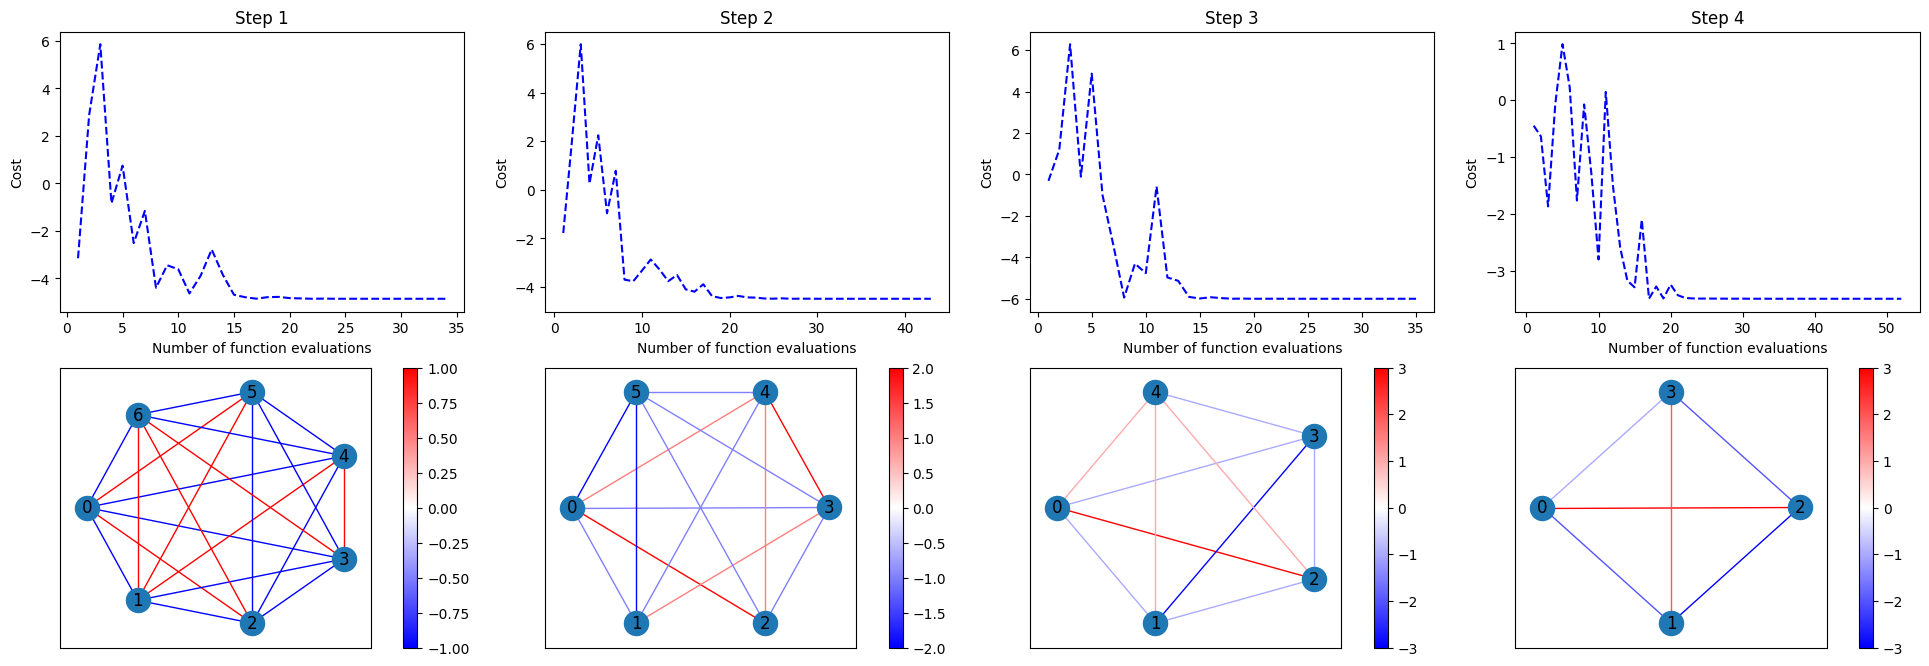

In [11]:
# Retrieve intermediate problem and QAOA optimization progress

# Number of recursive steps
num_steps = result['number_steps']

fig, ax = plt.subplots(2,num_steps, figsize = (24,8))

for i in range(num_steps):
    
    # Get the QUBO problem and QAOA result object for the last step
    qaoa_results = result.get_qaoa_results(step = i)
    qubo_problem = result.get_problem(step = i)
    terms = [term.qubit_indices for term in qubo_problem.hamiltonian.terms]
    weights = [weight for weight in qubo_problem.hamiltonian.coeffs]
    
    # Extract problem graph
    qubo_graph = nx.Graph()
    weighted_edges = [ tuple(list(term) +[weight]) for term,weight  in zip(terms,weights)]
    qubo_graph.add_weighted_edges_from(weighted_edges)
    
    # Plot cost optimization
    qaoa_results.plot_cost(ax = ax[0][i])
    ax[0][i].set_title(f'Step {i+1}')
    ax[0][i].get_legend().remove()
    
    # Plot problem graph
    nx.draw_networkx(qubo_graph, pos = nx.shell_layout(qubo_graph), ax = ax[1][i], edge_color = weights, edge_cmap = plt.colormaps["bwr"])
    sm = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    cbar = plt.colorbar(sm, pad=0.08, ax = ax[1][i])

In these plots we can appreciate an important aspect of RQAOA: the topology of the problem will evolve unpredictably throughout the recursive process. In this case, where we only consider quadratic terms, the only constraint that will be imposed is that of fixing one qubit with respect to a second one. In the language of graphs, this can be understood as merging two nodes, where the remaining node inherits all the edges from the merged one. From the point of view of the Hamiltonian, the couplings associated with qubits that were connected to both of the merged qubits will add up. For example, if we merge qubit $i$ into qubit $j$, and both where connected to qubit $k$ through couplings $J_{ik}$ and $J_{jk}$, the resulting connection between the remaining qubit $j$ and qubit $k$ will be $J_{jk} \mapsto J_{jk} + J_{ik}$. You can easily check this by yourself by defining some generic Hamiltonian and imposing the constraint defined in the introduction! As a result, some edges will acquire values beyond the initial definition $|J_{ij}| = 1$. Furthermore, sometimes the couplings will cancel each other, resulting in certain edges disappearing from the graph. This can be observed on the second step of the process above, where the connection between qubits 1 and 2 has disappeared. Through the same mechanism, new connections can emerge between previously disconnected qubits, e.g. in the third step all qubits are again connected with each other. 

If we had also included linear terms in the problem and the constraints associated will single-spin expectation values were to be imposed, the change of topology would correspond to removing a node from the graph along with all edges incident in it. 

Finally, to check the quality of our results, we compute the exact solution, which can be done for any Hamiltonian of reasonable size using the OpenQAOA utility function ``ground_state_hamiltonian``. To use this function we define the problem as an instance of the ``Hamiltonian`` class, using the ``classical_hamiltonian`` method (given that our Hamiltonian is only composed of $Z$ operators). This class is widely used across OpenQAOA to generate mixer and cost Hamiltonians that define the QAOA structure.

In [12]:
# Get RQAOA solutions
solutions = result.get_solution()
states = list(solutions.keys())
energy = list(solutions.values())[0]

# Obtain exact solution for comparison

# Define Hamiltonian object from terms and weights
hamiltonian = Hamiltonian.classical_hamiltonian(terms,weights,constant = 0)

# Compute the exact result
exact_energy, ground_state_strings = ground_state_hamiltonian(hamiltonian)

print(f'The solution found by RQAOA has energy = {energy} and ground states = {states}\n')

print(f'The exact energy is {exact_energy} and the solutions are {ground_state_strings}')

The solution found by RQAOA has energy = -9.0 and ground states = ['1100100', '0011011']

The exact energy is -7.0 and the solutions are ['1100', '0011']


As we can see, for this simple problem, RQAOA was able to to find two out of the four ground states!

## Run RQAOA on a QPU

To run RQAOA using OpenQAOA, now on a real quantum device, one simply needs to change the device parameters when defining the RQAOA instance, and voilà!

In [13]:
# Define an instance of the RQAOA class
r_qpu =  RQAOA()

# Set instance parameters
r_qpu.set_rqaoa_parameters(n_cutoff = 3, steps = 1, rqaoa_type = 'custom')

# Set the properties you want - These values are actually the default ones!
r_qpu.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

r_qpu.set_backend_properties(n_shots=500)

# Set the classical method used to optimiza over QAOA angles and its properties, note that to make the computation leaner we set a tollerance of 0.05
r_qpu.set_classical_optimizer(method='cobyla', maxiter=20, tol=0.05,  optimization_progress=True)

In [14]:
# Here are some of the simulators available through Azure Quantum, replacing the device with a real qpu
ionq_sim = 'ionq.simulator'
quantinuum_sim = 'quantinuum.sim.h1-1e'
rigetti_sim = 'rigetti.sim.qvm'

# Set the backend you want to use here.
# WARNING: Quantinuum simulator usage is not unlimited. Running this sample against it could consume a significant amount of your eHQC quota.
backend_to_use = ionq_sim

In [15]:
# Connect to the Azure Quantum workspace through OpenQAOA
resource_id = ''
az_location = ''

# Set a quantum device to run our instance
device = create_device(location='azure', name=backend_to_use, resource_id=resource_id, az_location=az_location)

In [16]:
r_qpu.set_device(device)

In [17]:
r_qpu.compile(problem)

Job submission to the Azure backend is made internally in the optimization loop in OpenQAOA.

This cell can take a few minutes to execute (note that executing on real QPUs can take longer run time).

In [18]:
# Job submission to Azure Quantum is done internally
r_qpu.optimize()

............................................................................................................................................................................................................................................................................................................................................................................

In [19]:
result_qpu = r_qpu.result

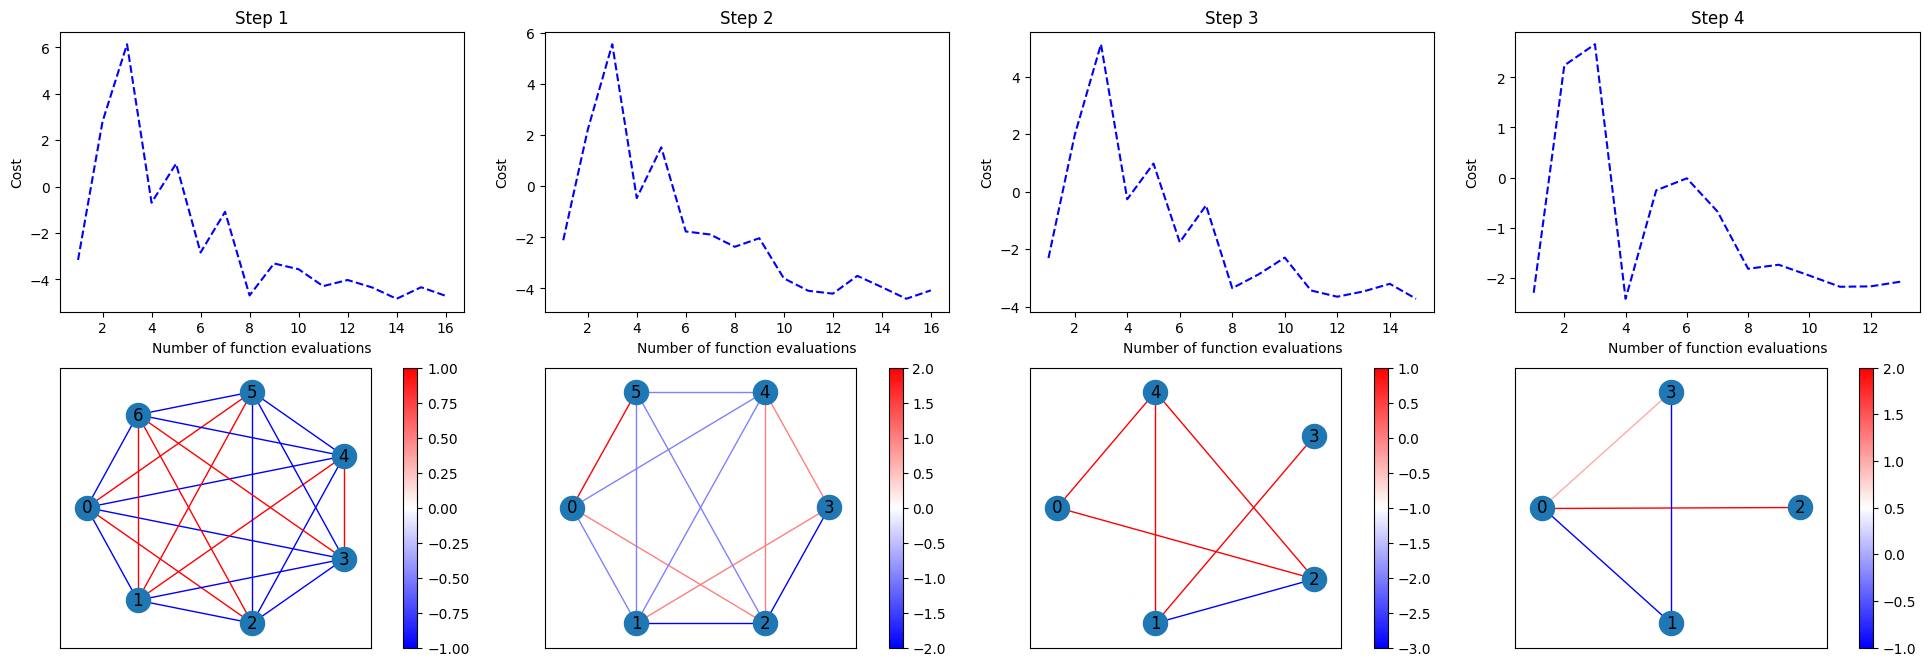

In [20]:
# Retrieve intermediate problem and QAOA optimization progress

# Number of recursive steps
num_steps = result['number_steps']

fig, ax = plt.subplots(2,num_steps, figsize = (24,8))

for i in range(num_steps):
    
    # Get the QUBO problem and QAOA result object for the last step
    qaoa_results = result_qpu.get_qaoa_results(step = i)
    qubo_problem = result_qpu.get_problem(step = i)
    terms = [term.qubit_indices for term in qubo_problem.hamiltonian.terms]
    weights = [weight for weight in qubo_problem.hamiltonian.coeffs]
    
    # Extract problem graph
    qubo_graph = nx.Graph()
    weighted_edges = [ tuple(list(term) +[weight]) for term,weight  in zip(terms,weights)]
    qubo_graph.add_edges_from(qubo_problem.terms)
    
    # Plot cost optimization
    qaoa_results.plot_cost(ax = ax[0][i])
    ax[0][i].set_title(f'Step {i+1}')
    ax[0][i].get_legend().remove()
    
    # Plot problem graph
    nx.draw_networkx(qubo_graph, pos = nx.shell_layout(qubo_graph), ax = ax[1][i], edge_color = weights, edge_cmap = plt.colormaps["bwr"])
    sm = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    cbar = plt.colorbar(sm, pad=0.08, ax = ax[1][i])

In [21]:
# Get RQAOA solutions
solutions_qpu = result_qpu.get_solution()
states_qpu = list(solutions_qpu.keys())
energy_qpu = list(solutions_qpu.values())[0]

# Obtain exact solution for comparison

# Define Hamiltonian object from terms and weights
hamiltonian = Hamiltonian.classical_hamiltonian(terms,weights,constant = 0)

# Compute the exact result
exact_energy, ground_state_strings = ground_state_hamiltonian(hamiltonian)

print(f'The solution found by RQAOA has energy = {energy_qpu} and ground states = {states_qpu}\n')

print(f'The exact energy is {exact_energy} and the solutions are {ground_state_strings}')

The solution found by RQAOA has energy = -9.0 and ground states = ['0011010', '1000100', '1100100', '0011011', '0111011', '1100101']

The exact energy is -3.0 and the solutions are ['1000', '1100', '0010', '1101', '0011', '0111']


Congrats! You have run two instances of RQAOA locally and on an Azure backend to find the solution to a binary optimization problem.

As a next step, you can modify the problem instance (see [OpenQAOA](https://el-openqaoa.readthedocs.io) for more examples), or run it on real QPUs.